<a href="https://colab.research.google.com/github/prerna-khanna/Air-Cognizer/blob/master/Feature_Extraction_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The given script was used for extracting features which are dependent upon the concentration of PM2.5 particles suspended in air and hence can be used for estimating the same. There are in total 6 image features:

1. Blue 

2. Transmission 

3. Gradient 

4. Root mean square of image

5. Constrast of ROI

6. Entropy

## Importing Libraries

In [10]:
import cv2;
import math;
import numpy as np;
import os, os.path;
from numpy import unique;
from scipy.stats import entropy as scipy_entropy
import xlwt;
from skimage import io,color
from google.colab import files
from google.colab.patches import cv2_imshow


print("Imported LIbraries Successfully")

Imported LIbraries Successfully


## Function for splitting color channels 


In [0]:
def Split(src):
    b,g,r = cv2.split(src);
    green = np.matrix(g);
    red = np.matrix(r);
    blue = np.matrix(b);
    print('rgb mean =',np.mean(r+g+b));

    lab = color.rgb2lab(src)
    l,a,c = cv2.split(lab);
    x = np.matrix(l);
    y = np.matrix(a);
    z = np.matrix(c);
    print('lab mean =',np.mean(x+y+z));

## Estimating Entropy
**Input** is the normalised grayscale image and a positive number which serves as base of logarithm in entropy estimation.

**Returns** entropy as a floating point number. 

In [0]:
def Entropy(normal, base = 2):  #2 is for log to the base 2

    _, counts = unique(normal, return_counts=True)
    return scipy_entropy(counts, base=base)

## Estimating Contrast of ROI
**Input** is the grascale image of ROI (for contrast ROI is non sky part) and returns the **contrast** as a floating point number. 

In [0]:
def Roi_Contrast(signal): 
    a = np.array(signal)
    normal = np.divide(a,255)
    b = np.mean(normal,dtype=np.float64)
    height,width = normal.shape[:2]

    for ix,iy in np.ndindex(normal.shape):
      
            c = normal[ix,iy]
            d = c-b
            d = d*d
            e = d
            d = d+e        
                        
    den = width*height
    rms = d/den
    return (math.sqrt(rms))    



## Estimating Gradient
**Input** is grayscale image and gradient is estimated of the ROI (for gradient ROI is the sky regoi of the image) and function returns **positive floating point number**. 

In [0]:
def Gradient(roi1):
    white = np.array([255,255,255])
    lowerBound = np.array([200,200,200])
    mask = cv2.inRange(roi1, lowerBound, white)
    laplacian = cv2.Laplacian(mask, cv2.CV_64F);
    gradient = cv2.split(laplacian);  
    
    return abs(np.mean(gradient))

##Blue color estimatoin 
**Input** is RGB image and outputs the **RMS of blue** color of sky. 

In [0]:
def Blue(im):
    b,g,r = cv2.split(im);
    blue = np.matrix(b);
    return np.mean(blue)
  

##RMS of the image
The **input** is the grayscale image and outputs the RMS as floating point number. 

In [0]:
def RMS(signal): 
    a = np.array(signal)
    normal = np.divide(a,255)
    b = np.mean(normal,dtype=np.float64)
    height,width = normal.shape[:2]

    for ix,iy in np.ndindex(normal.shape):
      
            c = normal[ix,iy]
            d = c-b
            d = d*d
            e = d
            d = d+e        
                        
    den = width*height
    rms = d/den
    return math.sqrt(rms)

## Transmission of Sky

Transmission is computed by Dark Channel Priori algorithm. Observed hazy image is product of transmission and scene radiance and airlight color vector. 

In [0]:
def DarkChannel(im,sz):                                                                        #Function is used to calculate dark channel
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):                                                                         #Function is used to determine Airlight color vector 
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):                                                             #Function is used to estimate Transmission of image
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):                                                                  #Function is used to apply guided filter for transmission enhancement
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):                                                                 #Function used to enhance transmission map
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);
    cv2_imshow(t)

    return t;
  
def Transmission_Val(t):                                                                       #Calculating transmission in terms of floating point number of sky 
    
    roi=t[376:376+164, 337:337+330]
    
    mean = np.matrix(roi);
    return abs(10000*np.mean(mean))

## Main Function 



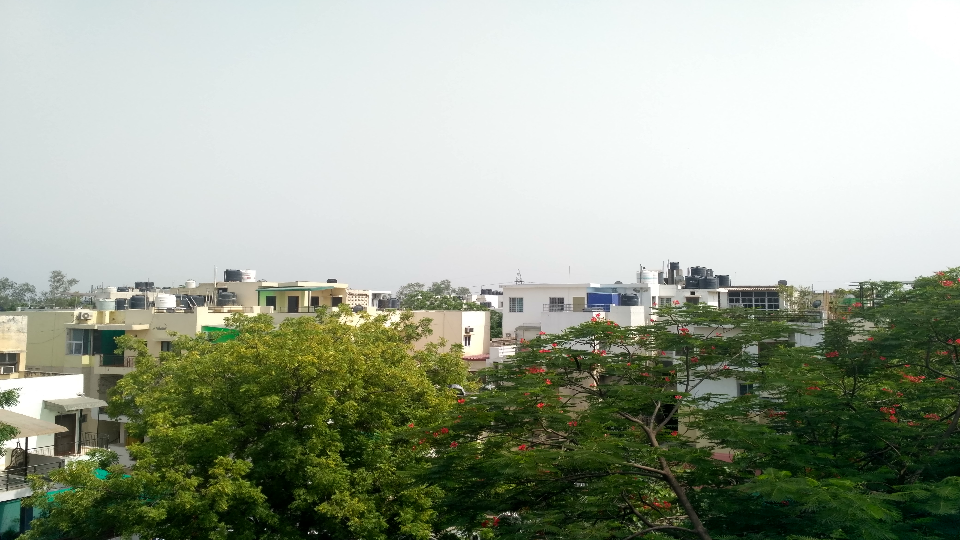

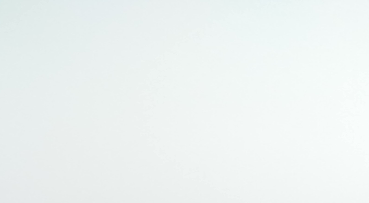

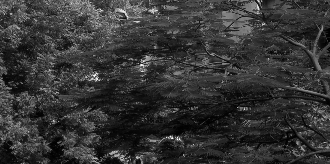

rgb mean = 158.25959104938272
lab mean = 60.43281066370167
blue =  0.9491017489137511
gradient =  0.0
transmission =  9990.489327053496
im contrast =  0.0011600236317782335
roi contrast =  8.74817333846796e-05
entropy =  7.277817609653172




In [22]:

if __name__ == '__main__':
    
    import sys
    try:
        fn = sys.argv[1]
    except:
        fn = r'394.jpg'

    def nothing(*argv):
        pass

    S = cv2.imread('394.jpg',1);
    src = cv2.resize(S,(960,540));
    cv2_imshow(src)

    I = src.astype('float64')/255;
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY);      


    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
            
    roi1=src[1:1+203, 298:298+369]
    cv2_imshow(roi1)
    
    blue = roi1.astype('float64')/255;
    
    roi=gray[376:376+164, 337:337+330]
    cv2_imshow(roi)
    normal = np.divide(gray,255)   
    
        
    bl=Blue(blue);
    gr=Gradient(roi1);
    tr=Transmission_Val(t);
    rms=RMS(gray);
    con=Roi_Contrast(roi);
    et=Entropy(normal);
    Split(src);
 
        
    print('blue = ',bl)
    print('gradient = ',gr)
    print('transmission = ',tr)
    print('im contrast = ',rms)
    print('roi contrast = ',con)
    print('entropy = ',et)
    print('\n');
    
